# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import math as mth
from scipy import stats as st

import matplotlib.pyplot as plt

import datetime as dt
from datetime import timedelta

# Цели и задачи проекта

В рамках проекта предстоит провести оценку результатов А/В теста изменений, связанных с внедрением улучшенной рекомендательной системы.

Необходимо:
- оценить корректность проведения теста;
- проанализировать результат.

## Техническое задание

- Название теста: recommender_system_test;
- Группы: А (контрольная), B (новая платёжная воронка);
- Дата запуска: 2020-12-07;
- Дата остановки набора новых пользователей: 2020-12-21;
- Дата остановки: 2021-01-04;
- Аудитория: 15% новых пользователей из региона EU;
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- Ожидаемое количество участников теста: 6000.
- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие product_page;
    - просмотры корзины — product_cart;
    - покупки — purchase.

# Загрузка данных

In [2]:
# функция для загрузки файлов

def file_loader(file_name):
    try:
        file = pd.read_csv(file_name)
        print('loaded from local source')
        return file
        
    except:
        try:
            file = pd.read_csv('https://code.s3.yandex.net/datasets/' + file_name)
            print('loaded from web source')
            return file
        except:
            print('not loaded')

In [3]:
# календарь маркетинговых событий на 2020 год

ab_project_marketing_events = file_loader('ab_project_marketing_events.csv')

loaded from local source


In [4]:
# все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года;

final_ab_new_users = file_loader('final_ab_new_users.csv')

loaded from local source


In [5]:
# все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года

final_ab_events = file_loader('final_ab_events.csv')

loaded from local source


In [6]:
# таблица участников тестов

final_ab_participant = file_loader('final_ab_participants.csv')

loaded from local source


## Описание данных

### ab_project_marketing_events.csv

календарь маркетинговых событий на 2020 год.

Структура файла:
- name — название маркетингового события;
- regions — регионы, в которых будет проводиться рекламная кампания;
- start_dt — дата начала кампании;
- finish_dt — дата завершения кампании.

### final_ab_new_users.csv

все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года.

Структура файла:
- user_id — идентификатор пользователя;
- first_date — дата регистрации;
- region — регион пользователя;
- device — устройство, с которого происходила регистрация.

### final_ab_events.csv

все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:
- user_id — идентификатор пользователя;
- event_dt — дата и время события;
- event_name — тип события;
- details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

### final_ab_participants.csv

таблица участников тестов.

Структура файла:
- user_id — идентификатор пользователя;
- ab_test — название теста;
- group — группа пользователя.

# Оценка качества данных, предобработка данных

## Проверка заголовков

In [7]:
head = [ab_project_marketing_events, final_ab_new_users, final_ab_events, final_ab_participant]

for i in head:
    display(i.head(1))

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test


Названия столбцов оставляем без изменений

## Пропущенные значения

In [8]:
for i in head:
    display(i.info())
    print('-'*50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

--------------------------------------------------


Пропущенные значения в final_ab_events, столбец details. Большой объем пропусков, данные в данном столбце явлюяются дополнительной информацией, оставим без изменения.

## Тип данных

In [9]:
# преобразуем столбцы дата-время в соответствующий формат

ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'])

ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'])

final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'])

final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'])

## Дубли

In [10]:
# датафрейм:

ab_project_marketing_events.head(1)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


In [11]:
# полные дубли 

ab_project_marketing_events.duplicated().sum()

0

In [12]:
# дубли в наименовании

ab_project_marketing_events['name'].duplicated().sum()

0

___

In [13]:
# датафрейм:

final_ab_new_users.head(1)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC


In [14]:
# полные дубли 

final_ab_new_users.duplicated().sum()

0

In [15]:
# названия регионов

final_ab_new_users['region'].unique()

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

In [16]:
# device

final_ab_new_users['device'].unique()

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

___

In [17]:
# датафрейм:

final_ab_events.head(1)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99


In [18]:
# полные дубли 

final_ab_events.duplicated().sum()

0

In [19]:
# названия событий

final_ab_events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

___

In [20]:
# датафрейм:

final_ab_participant.head(1)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test


In [21]:
# полные дубли 

final_ab_participant.duplicated().sum()

0

In [22]:
# дубли user_id

final_ab_participant['user_id'].duplicated().sum()

1602

In [23]:
final_ab_participant['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

Видим наличие дублей. Возможно связано с некорректным разнесением по группам, возможно с отбором одних и тех же пользователей на разные тесты.

In [24]:
# добавим фильтр по тесту

final_ab_participant.query('ab_test == "recommender_system_test"')['user_id'].duplicated().sum()

0

In [25]:
# проверим пересечение с тестовой группой конкуририующего теста

final_ab_participant.query(
    'ab_test == "recommender_system_test" | \
    group == "B"'
                            )\
        ['user_id'].duplicated().sum()

783

Видим пересечение с тестовой группой конкурирующего теста.

In [26]:
# Удалим пересечения с тестовой группой конкурирующего теста

final_ab_participant = final_ab_participant[~final_ab_participant['user_id'].isin(
    final_ab_participant.query('ab_test == "interface_eu_test" & group == "B"')['user_id']
                                                                                    )
                                             ]

In [27]:
# удалим оставшиеся данные конкурирующего теста

final_ab_participant = final_ab_participant[final_ab_participant['ab_test'] == 'recommender_system_test']

In [28]:
final_ab_participant.shape

(5918, 3)

- удалили пересечения с конкурирующим тестом;
- объем данных стал меньше заявленного в ТЗ.

## Аномальные значения

### Диапазон дат маркетинговых активностей

In [29]:
# проверим диапазон дат маркетинговых активностей

ab_project_marketing_events['start_dt'].min(), ab_project_marketing_events['start_dt'].max()

(Timestamp('2020-01-25 00:00:00'), Timestamp('2020-12-30 00:00:00'))

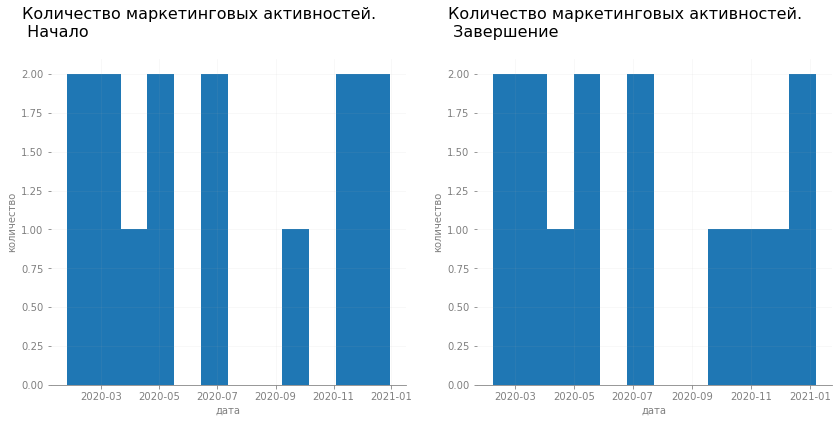

In [30]:
# построим гистрограммы по датам начала и завершения

# функция - настройка параметров графика
def hist_set(title=' ',
            xlabel=' ',
            ylabel=' '):
 # настройка видимости рамок
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('grey') #  цвет лини оси X

    plt.grid(True, alpha=0.1) # отображение сетки
    ax.tick_params(colors='grey', labelsize = 10) # настройка значений осей

        # заголовок
    plt.title(title, size = 16, loc='left',
                      y= 1.05, x = -0.08 )
    plt.xlabel(xlabel, fontsize=10, color='grey') # подпись оси Х
    plt.ylabel(ylabel, fontsize=10, color='grey') # подпись оси Y

plt.figure(figsize=(14, 6))

#график 1
plt.subplot(1, 2, 1)

ax = ab_project_marketing_events['start_dt'].hist(bins=12)

hist_set(title='Количество маркетинговых активностей.\n Начало',
            xlabel='дата',
            ylabel='количество')

#график 2
plt.subplot(1, 2, 2)

ax = ab_project_marketing_events['finish_dt'].hist(bins=12)

hist_set(title='Количество маркетинговых активностей.\n Завершение',
            xlabel='дата',
            ylabel='количество')

Можно отметить: наличие маркетинговых мероприятий, приходящихся на даты теста. Соответсвие региону тестирования уточним позднее.

___

### Диапазон дат регистрации новых пользователей

In [31]:
# проверим диапазон дат регистрации новых пользователей

final_ab_new_users['first_date'].min(), final_ab_new_users['first_date'].max()

(Timestamp('2020-12-07 00:00:00'), Timestamp('2020-12-23 00:00:00'))

Дата остановки набора новых пользователей: 2020-12-21, Проверим попали ли группы А/В теста.

In [32]:
final_ab_new_users.merge(final_ab_participant, on='user_id', how='right')['first_date'].max()

Timestamp('2020-12-21 00:00:00')

Новые пользователи, набранные после 2020-12-21, не попали в группы А/В теста.

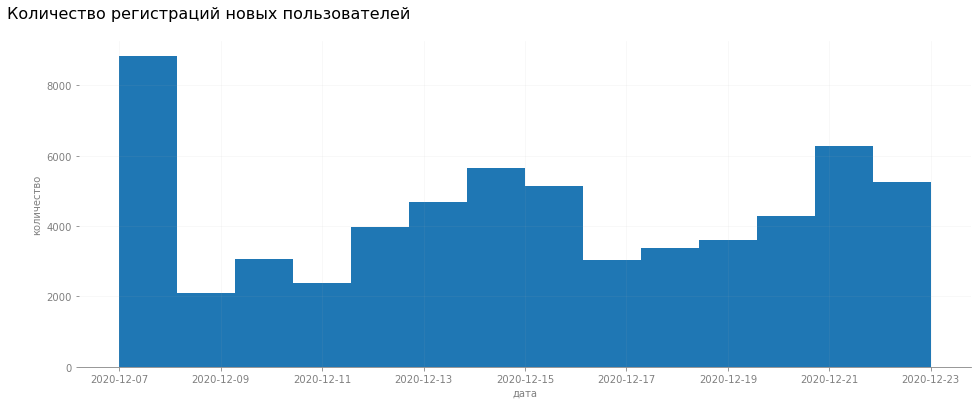

In [33]:
# построим гистограмму распределения регистрации новых пользователей

plt.figure(figsize=(16, 6))

ax = final_ab_new_users['first_date'].hist(bins=14)

hist_set(title='Количество регистраций новых пользователей',
            xlabel='дата',
            ylabel='количество');

Видим пик регистрации пользователей 21-12-20, в последний день отбора для теста.

___

In [34]:
# проверим диапазон дат действий пользователей

final_ab_events['event_dt'].min(), final_ab_events['event_dt'].max()

(Timestamp('2020-12-07 00:00:33'), Timestamp('2020-12-30 23:36:33'))

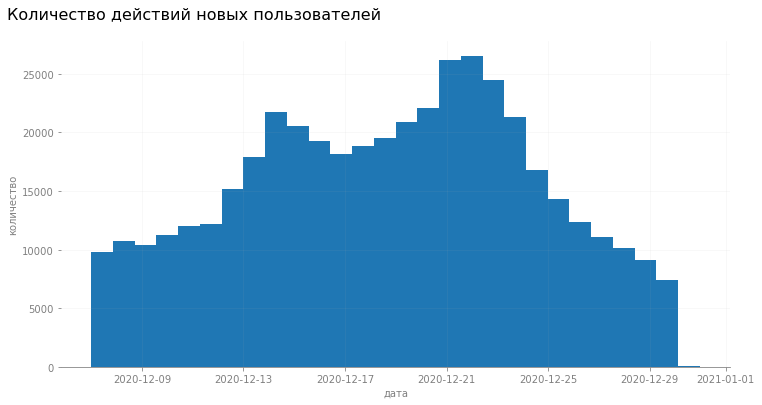

In [35]:
# построим гистограмму распределения действий пользователей

plt.figure(figsize=(12, 6))

ax = final_ab_events['event_dt'].hist(bins=28)

hist_set(title='Количество действий новых пользователей',
            xlabel='дата',
            ylabel='количество');

In [36]:
final_ab_events[final_ab_events['event_dt'] >= '30-12-20'].shape[0]

89

Диапазон дат оставляем без изменений. Видим пик событий приходится на 21/22 -12-20. Можем отметить существенное подение активности пользователей после 30-12-20(включительно)

# Оценка корректности проведения теста

## Соответствие данных требованиям технического задания

Пройдем по ТЗ

- Название теста: recommender_system_test; <br/>
*Данные присутсвуют*

- Группы: А (контрольная), B (новая платёжная воронка);<br/>
*Данные присутсвуют*

- Дата запуска: 2020-12-07;<br/>
*Данные присутсвуют*

- Дата остановки набора новых пользователей: 2020-12-21;<br/>
*Данные присутсвуют*

- Дата остановки: 2021-01-04;<br/>
*Данные присутсвуют, можем отметить сущенственное падение объема данных после 29-12-20*

- Аудитория: 15% новых пользователей из региона EU; <br/>
*Проверим*

In [37]:
# Общее количество новых пользователей в Европейском регионе

total_new_users = final_ab_new_users.query('region == "EU"')['user_id'].nunique()
total_new_users

46270

In [38]:
# Участники А/В теста из не Европейского региона

final_ab_participant[final_ab_participant['user_id'].\
                      isin(final_ab_new_users.query('region != "EU"')['user_id'])].shape[0]

350

Видим, попали пользователи из других регионов, удалим.

In [39]:
final_ab_participant = final_ab_participant[final_ab_participant['user_id'].\
                       isin(final_ab_new_users.query('region == "EU"')['user_id'])]

In [40]:
# число пользователей в тесте

users_in_test = final_ab_participant['user_id'].nunique()

In [41]:
# процент новых пользователей задействованых в тесте

'{0:.2f}%'.format((users_in_test/total_new_users)*100)

'12.03%'

По итогу получили менее 15% выборки.

- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;<br/>
*Исходя из данных сложно сделать вывод*

- Ожидаемое количество участников теста: 6000. <br/>
*Проверим*

In [42]:
users_in_test

5568

В тесте участвуют менее 6000 человек.

- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие product_page;
    - просмотры корзины — product_cart;
    - покупки — purchase. <br/>
    
*данные по метрикам присутсвуют*<br/>
Корректность:<br/>
- улучшение на 10% - абсолютный или относительный прирост(метрика + 10% или метрика * 1.1)?<br/>
- у нас есть данные по событиям:<br/>
login -- > product_page -- > product_cart --> purchase <br/>
В такой логике клиент после логирования попадает на карточку товара. 
Мы тестируем рекомендательную систему. После регистрации у нас, скорее всего, минимум данных о пользователе, мы еще не успели собрать информацию о его поведении;<br/>
Под покупкой подразумевается переход к оформлению покупки(вводу платежных данных) или факт оплаты? Если речь идет о факте оплаты есть риск получить снижение конверсии из-за сбоя проведения оплаты;<br/>
**Можем сделать вывод**:
- пропущен ряд событий,
- необходимо уточнить на каком этапе работают рекомендации.

Можем отметить:
- в рамках ТЗ не предполагается проводилось A/A тестирование;
- не указана необходимость подтверждения статистической значимости и уровень $\alpha$

## Время проведения теста

Можем отметь:
- время проведения - канун новгодних праздников, празднование католического Рождества;
- наличие маркетинговых активностей

In [43]:
# напишем функцию для определеня принадлежности к Европейскому региону

def eu_in_marketing_events(row):
    
    if 'EU' in row:
        return True
    
    else:
        return False

In [44]:
# Выделим в отдельный столбец принадлежность маркетинговой активности к Европейскому региону

ab_project_marketing_events['eu_marketing'] = ab_project_marketing_events['regions']\
    .apply(eu_in_marketing_events)
    
# Отфильтруем по Европейскому региону

eu_in_marketing_events_df = ab_project_marketing_events[ab_project_marketing_events['eu_marketing'] == True]

eu_in_marketing_events_df

,name,regions,start_dt,finish_dt,eu_marketing
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03,True
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16,True
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19,True
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19,True
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01,True
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03,True
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10,True


In [45]:
# найдем активности, которые проходили во время теста

eu_in_marketing_events_df[
    np.logical_and(
                    eu_in_marketing_events_df['start_dt'] <= '2021-01-04',
                    eu_in_marketing_events_df['finish_dt'] >= '2020-12-07'
                  )
                            ]

,name,regions,start_dt,finish_dt,eu_marketing
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03,True


Видим наличие маркетинговой активностей в момент проведения теста.

**Можем сделать вывод** о не самом оптимальном времени проведения теста, наличие праздничных дней и маркетинговых активностей приведет к неестественному поведению пользователей, появлению аномалий. Хотя праздничные дни и маркетинговые мероприятия влияют на обе группы, следует учесть при изучении абсолютных показателей.

## Корректность остановки теста

Проверим стабильность результатов к моменту окончания теста

In [46]:
# отфильтруем пользователей участвующих в тесте

users_ab_events = final_ab_participant.merge(final_ab_events, on='user_id', how='left')

In [47]:
# преобразуем дату-время в дату

users_ab_events['date'] = users_ab_events['event_dt'].dt.date

# датафрейм с уникальными дата-группа

users_ab_date_events = users_ab_events[['date', 'group']].drop_duplicates()\
    .sort_values(by='date')
users_ab_date_events.head()

,date,group
0,2020-12-07,A
105,2020-12-07,B
180,2020-12-08,B
14,2020-12-08,A
55,2020-12-09,A


In [48]:
# оставим только первое уникальное действие пользователя

users_ab_events = users_ab_events.groupby(['user_id', 'event_name', 'group'],
    as_index=False).agg({'date':'min'})

In [49]:
# количество пользователей совершивших како-либо действие в определенный день с накоплением

events_aggregated = users_ab_date_events.apply(
    lambda x:
        users_ab_events[np.logical_and(users_ab_events['date'] <= x['date'],
                                      users_ab_events['group'] == x['group'])].
            agg(
                {
                    'date': 'max',
                    'group': 'max',
                    'user_id':'nunique'}
               ), axis=1

                                          )
events_aggregated = events_aggregated.rename(columns={'user_id':'users_events_count'})
events_aggregated.head()

,date,group,users_events_count
0,2020-12-07,A,122.0
105,2020-12-07,B,142.0
180,2020-12-08,B,180.0
14,2020-12-08,A,205.0
55,2020-12-09,A,275.0


In [52]:
events_dict = {
    'login':'логирование',
    'product_page':'просмотр страницы продукта',
    'product_cart':'просмотр корзины',
    'purchase':'покупка'
}

In [53]:
# функция считает воронку по конкретному событию(накопленные значения)
# cтроит линейный график график

def event_percent(event, legend=True):
    ''' в качестве аргумента принимает наименование события (совершенное пользователем действие),
    legend - отображение подписи линий
    '''
    
    # фильтруем по событию
    users_ab_event = users_ab_events.query('event_name == @event')
    
    
    # считаем количество событий с накоплением
    event_aggregated = users_ab_date_events.apply(
        lambda x:
            users_ab_event[np.logical_and(users_ab_event['date'] <= x['date'],
                                          users_ab_event['group'] == x['group'])].
                agg(
                    {
                        'date': 'max',
                        'group': 'max',
                        'event_name': 'count'}
                   ), axis=1

                                              )

    #переименуем столбцы
    event_aggregated = event_aggregated.rename(columns={'event_name':'event_count'})
    
    # объединим с количеством пользователей совершивших какое-либо действие по дням
    event_aggregated = event_aggregated.merge(events_aggregated[['date', 'group', 'users_events_count']],
                                              on=['date', 'group'])

    # посчитаем воронку
    event_aggregated = event_aggregated.assign(event_percent = lambda x:
                                               ((x['event_count']/x['users_events_count'])*100).round(2))
    
    # построим график
    fig, ax = plt.subplots(figsize = (12,6))

    # датафреймы по группам
    events_aggregated_a = event_aggregated.query('group == "A"')
    events_aggregated_b = event_aggregated.query('group == "B"')

    # графики
    plt.plot(events_aggregated_a['date'], events_aggregated_a['event_percent'],
             linewidth = '3', color = '#ed8939')

    plt.plot(events_aggregated_b['date'], events_aggregated_b['event_percent'],
             linewidth = '3', color = '#3c76af')

    # настройка видимости рамок
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('grey') #  цвет лини оси X

    plt.grid(True, alpha=0.2, axis='y') # отображение сетки
    ax.tick_params(colors='grey', labelsize = 10) # настройка значений осей

    # заголовок
    plt.title(events_dict[event], size = 16, loc='left',
                  y= 1.05, x = -0.08 )
    plt.xlabel('дата', fontsize=10, color='grey') # подпись оси Х
    plt.ylabel('%', fontsize=10, color='grey') # подпись оси Y
    
    # легенда
    if legend == True:
        plt.annotate('группа A', # текст
            (events_aggregated_a[-2:-1]['date'],
             events_aggregated_a[-1:]['event_percent'].values), # координаты 
            textcoords="offset points", # расположение текста
            xytext=(35,-2), # расстояние от координат (x,y)
            ha='center', size=12, color = '#ed8939') 

        plt.annotate('группа В', # текст
            (events_aggregated_b[-2:-1]['date'],
             events_aggregated_b[-1:]['event_percent'].values), # координаты 
            textcoords="offset points", # расположение текста
            xytext=(35,-2), # расстояние от координат (x,y)
            ha='center', size=12, color = '#3c76af');

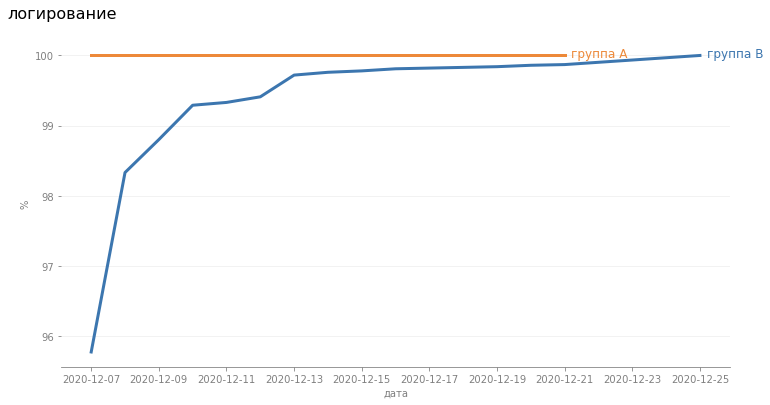

In [54]:
event_percent('login')

__Можно отметить__ стабильность результатов к окончанию теста

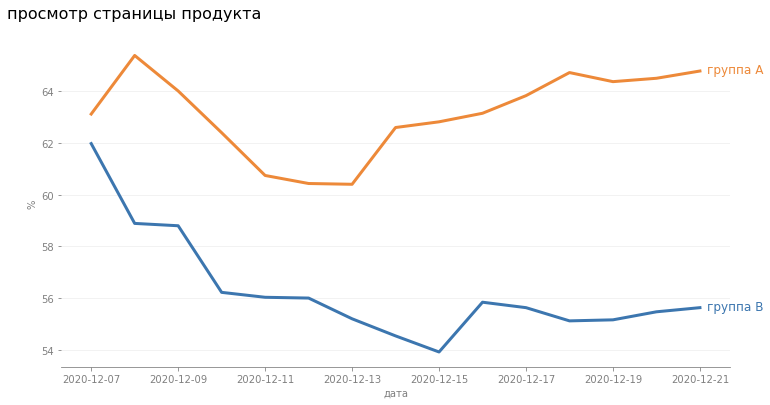

In [55]:
event_percent('product_page')

__Можно отметить__ стабильность результатов к окончанию теста

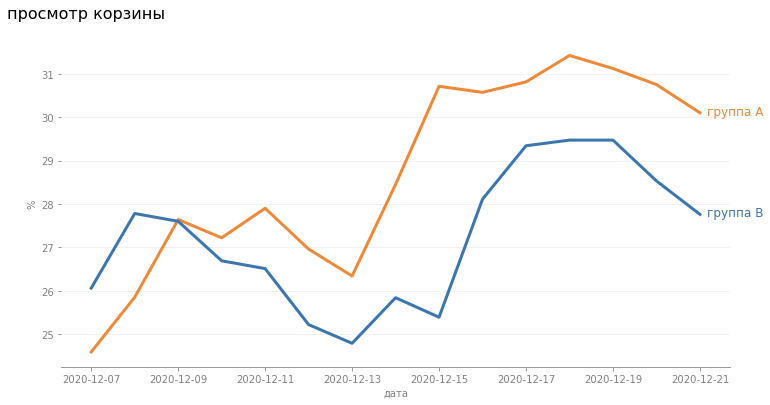

In [56]:
event_percent('product_cart')

Видим снижение в течение 3-х дней к окончанию теста (1-2%) 

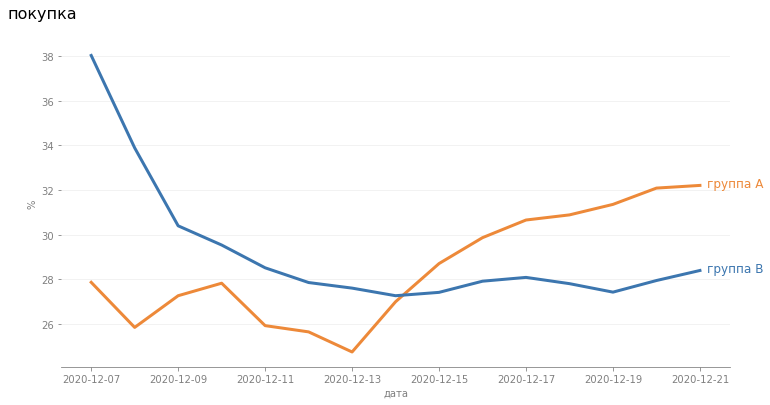

In [57]:
event_percent('purchase')

Стабильность группы В и возрастающий график группы А к окончанию теста

## Аудиторию теста

Ранее было отмечено:
- пересечение пользователей с конкурирующим тестом;
- отсутсвие пользователей участвующих в двух группах.

In [58]:
# количество пользователей в группе А

sample_a = final_ab_participant[final_ab_participant['group']=="A"]
sample_a.shape[0]

3195

In [59]:
# количество пользователей в группе В

sample_b = final_ab_participant[final_ab_participant['group']=="B"]
sample_b.shape[0]

2373

In [60]:
# % пользователей группы А

sample_a.shape[0]/final_ab_participant.shape[0]

0.5738146551724138

Примем к сведению неравномерное разбиение по группам (57 / 43)

In [61]:
# сформируем выборки по дате регистрации

sample_a_reg = final_ab_new_users[final_ab_new_users['user_id'].isin(sample_a['user_id'])]

sample_b_reg = final_ab_new_users[final_ab_new_users['user_id'].isin(sample_b['user_id'])]

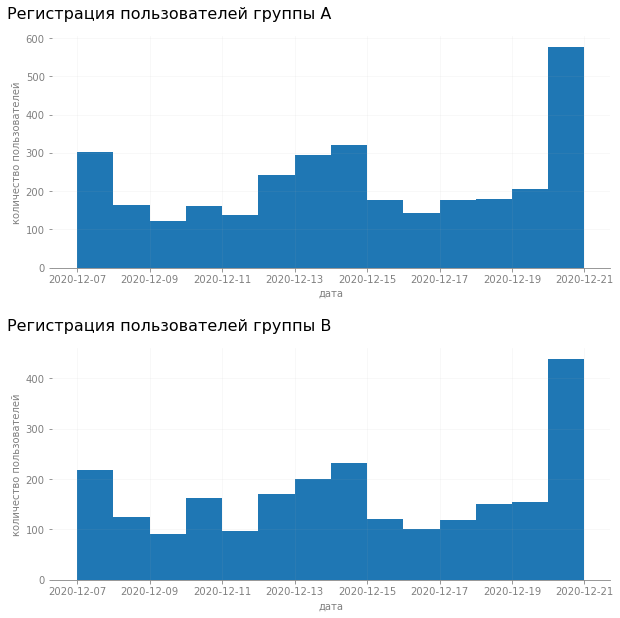

In [62]:
# построим гистограммы распределения пользователей по дате регистрации

plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)

ax = sample_a_reg['first_date'].hist(bins=14)

hist_set(title='Регистрация пользователей группы А',
            xlabel='дата',
            ylabel='количество пользователей')

plt.subplot(2, 1, 2)

ax =  sample_b_reg['first_date'].hist(bins=14)

hist_set(title='Регистрация пользователей группы В',
            xlabel='дата',
            ylabel='количество пользователей')

plt.subplots_adjust(hspace=0.35);

Видим схожее распределение по дате регистрации.

In [63]:
# отберем пользователей из группы А совершавших действия

sample_a_events = final_ab_events[final_ab_events['user_id'].isin(sample_a['user_id'])]

# события должны происхдить не позднее 14 дней после регистрации

# сформируем датафрейм с максимальной датой до которой должны происхдить события

max_dt_test = pd.DataFrame(final_ab_new_users[['user_id', 'first_date']])

# добавим к дате регистрации 14 дней

max_dt_test['max_dt_for_test'] = max_dt_test['first_date'] + timedelta(days= 14)

# добавим ограничевующую дату в датафрейм с ранее отобранными пользователями

sample_a_events = sample_a_events.merge(max_dt_test, how='left', on='user_id')

# отфильтруем по дате

sample_a_events = sample_a_events[sample_a_events['event_dt'] <= sample_a_events['max_dt_for_test']]

In [64]:
# проделаем то же самое для группы В

# cформируем выборки по дате событий(действий)

sample_b_events = final_ab_events[final_ab_events['user_id'].isin(sample_b['user_id'])]

# добавим ограничевующую дату в выборку

sample_b_events = sample_b_events.merge(max_dt_test, how='left', on='user_id')

# отфильтруем по дате

sample_b_events = sample_b_events[sample_b_events['event_dt'] <= sample_b_events['max_dt_for_test']]

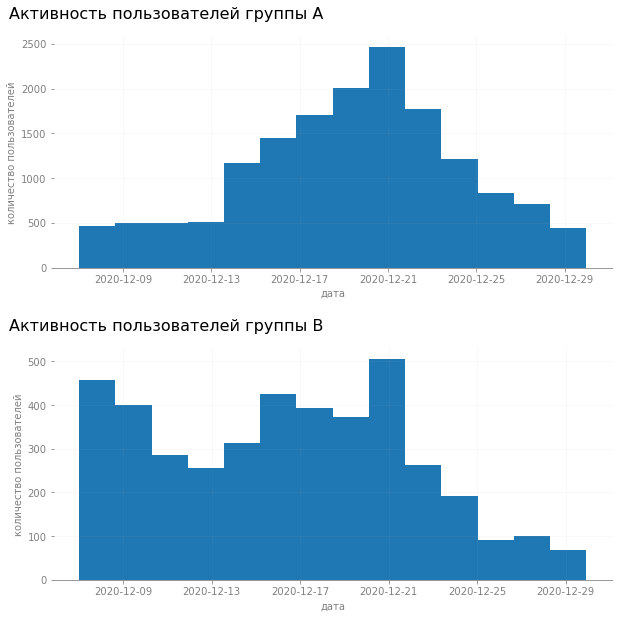

In [65]:
# построим гистограммы распределения пользователей по дате событий(действий)

plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)

ax = sample_a_events['event_dt'].hist(bins=14)

hist_set(title='Активность пользователей группы А',
            xlabel='дата',
            ylabel='количество пользователей')

plt.subplot(2, 1, 2)

ax = sample_b_events['event_dt'].hist(bins=14)

hist_set(title='Активность пользователей группы В',
            xlabel='дата',
            ylabel='количество пользователей')
plt.subplots_adjust(hspace=0.35);

Видим различия в распределении активности(событий) пользователей. В контрольной выборке пик активности приходится на середину теста и сниженная активность в начале и в конце теста. В тестовой пики в начале и в середине теста, к концу теста спад активности. Подобное различие может говорить о поведенчиских различиях пользователей в разных группах.

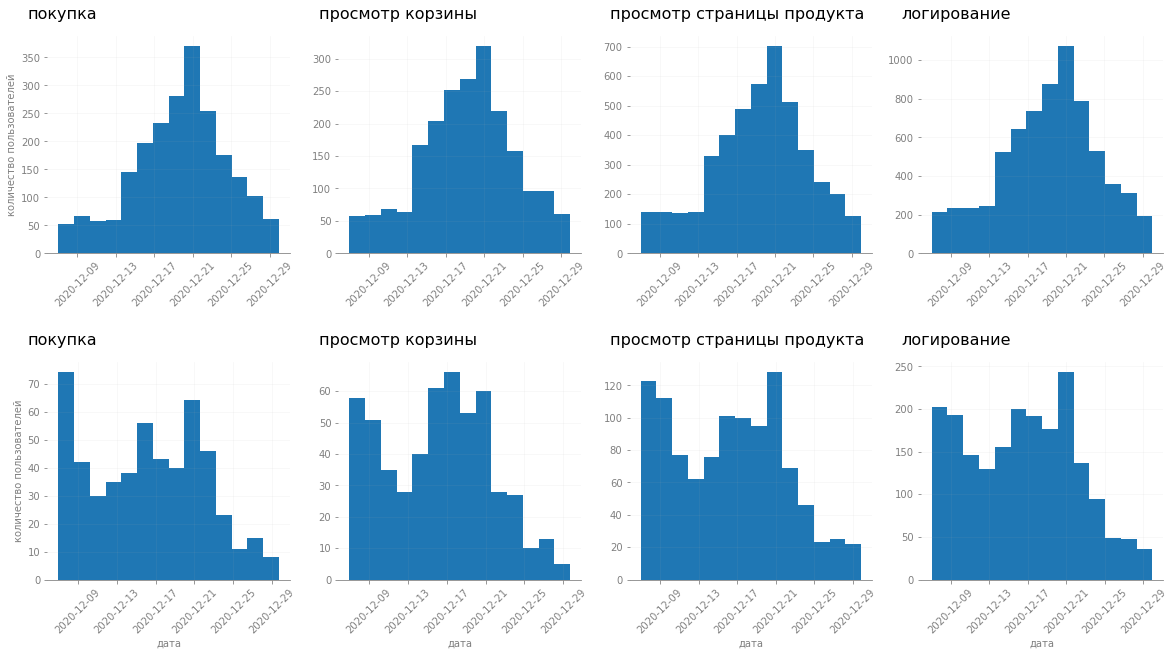

In [66]:
# построим гистограммы распределения пользователей по дате по отдельным событиям(действиям)

plt.figure(figsize=(20, 10))

hist_counter = 1

for sample in [sample_a_events, sample_b_events]:
    for event in final_ab_events['event_name'].unique():
        tmp_sample = sample[sample['event_name'] == event]
        
        plt.subplot(2, 4, hist_counter)
        
        ax = tmp_sample['event_dt'].hist(bins=14)

        if hist_counter == 1:
             hist_set(title=events_dict[event],
                 xlabel='',
                 ylabel='количество пользователей')
        elif hist_counter == 5:
            hist_set(title=events_dict[event],
                 xlabel='дата',
                 ylabel='количество пользователей')
        elif hist_counter > 5:
            hist_set(title=events_dict[event],
                 xlabel='дата',
                 ylabel='')
        else:
            hist_set(title=events_dict[event],
                 xlabel='',
                 ylabel='')
            
        plt.subplots_adjust(hspace=0.5)
        plt.xticks(rotation = 45)
        
        hist_counter += 1

Видим схожее распределение по каждому наименованию события

# Исследовательский анализ

## Количество событий на пользователя

Посчитаем количество пользователей которые зарегистрировались, совершали какие-либо действия

In [67]:
# группа А

a_reg = sample_a_reg['user_id'].nunique()

In [68]:
a_events = sample_a_events['user_id'].nunique()

In [69]:
print(f'зарегистрировалось: {a_reg}')
print(f'совершили какое-либо действие: {a_events}')
print(f'совершили какое-либо действие {round(a_events/a_reg, 2)}% зарегистрировавшихся пользователей')

зарегистрировалось: 3195
совершили какое-либо действие: 2279
совершили какое-либо действие 0.71% зарегистрировавшихся пользователей


In [70]:
# количество уникальных событий на пользователя

print('Уникальных событий на пользователя (среднее):\n',
round(sample_a_events.groupby('user_id').agg({'event_name':'nunique'})['event_name'].mean(), 1))

Уникальных событий на пользователя (среднее):
 2.3


In [71]:
a_events_per_user = sample_a_events.groupby('user_id').agg({'event_name':'count'})

print('Среднее количество событий на пользователя (медиана):\n',
np.percentile(a_events_per_user['event_name'], 50))

Среднее количество событий на пользователя (медиана):
 6.0


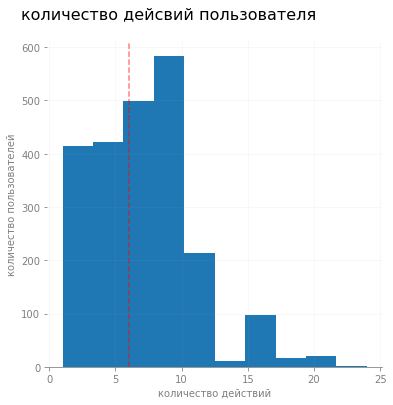

In [72]:
plt.figure(figsize=(6, 6))

ax = a_events_per_user['event_name'].hist(bins=10)

hist_set(title='количество дейсвий пользователя',
                 xlabel='количество действий',
                 ylabel='количество пользователей')
plt.axvline(x= np.percentile(a_events_per_user['event_name'], 50),  linestyle = 'dashed' ,
           color = 'r', alpha=0.5);

В большинстве случаев пользователи совершали до 10 действий

___

In [73]:
# группа В

b_reg = sample_b_reg['user_id'].nunique()

In [74]:
b_events = sample_b_events['user_id'].nunique()

In [75]:
print(f'зарегистрировалось: {b_reg}')
print(f'совершили какое-либо действие: {b_events}')
print(f'совершили какое-либо действие {round(b_events/b_reg, 2)}% зарегистрировавшихся пользователей')

зарегистрировалось: 2373
совершили какое-либо действие: 771
совершили какое-либо действие 0.32% зарегистрировавшихся пользователей


In [76]:
# количество уникальных событий на пользователя

print('Уникальных событий на пользователя (среднее):\n',
round(sample_b_events.groupby('user_id').agg({'event_name':'nunique'})['event_name'].mean(), 1))

Уникальных событий на пользователя (среднее):
 2.1


In [77]:
b_events_per_user = sample_b_events.groupby('user_id').agg({'event_name':'count'})

print('Среднее количество событий на пользователя (медиана):\n',
np.percentile(b_events_per_user['event_name'], 50))

Среднее количество событий на пользователя (медиана):
 4.0


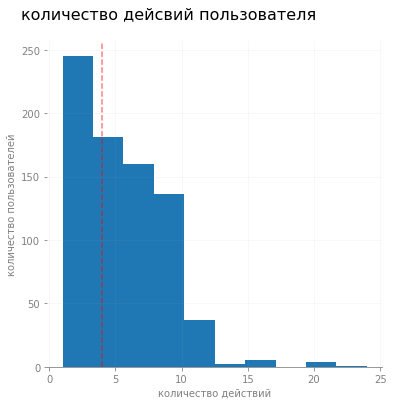

In [78]:
plt.figure(figsize=(6, 6))

ax = b_events_per_user['event_name'].hist(bins=10)

hist_set(title='количество дейсвий пользователя',
                 xlabel='количество действий',
                 ylabel='количество пользователей')
plt.axvline(x= np.percentile(b_events_per_user['event_name'], 50),  linestyle = 'dashed' ,
           color = 'r', alpha=0.5);

В большинстве случаев пользователи совершали до 10 действий, но в отличие от группы А пик приходится на 1-2 события.

__Можем отметить:__
- схожее среднее количество уникальных события на пользователя; 
- в контрольной группе среднее(медиана) количество событий на пользователя больше.

## Как число событий в выборках распределено по дням

Ранее отмечали различия в распределении активности(событий) пользователей. В контрольной выборке пик активности приходится на середину теста и сниженная активность в начале и в конце теста. <br/> В тестовой пики в начале и в середине теста к концу теста спад активности.<br/> Подобное различие может говорить о поведенчиских различиях пользователей в разных группах.

__Посчитаем сколько дней понадобилось пользователям для совершения первого действия__

In [79]:
# отфильтруем действия только пользователей участвующих в эксперименте

events_participiant = final_ab_participant[['user_id', 'group']].\
    merge(final_ab_events[['user_id', 'event_dt', 'event_name']], on='user_id', how='left')

events_participiant.shape

(23082, 4)

In [80]:
#  оставим только первое уникалльное действие

events_participiant = events_participiant\
    .groupby(['user_id', 'event_name', 'group'], as_index=False).agg({'event_dt':'min'})

In [81]:
# добавим дату регистрации

events_participiant_new_user = events_participiant.\
    merge(final_ab_new_users[['user_id', 'first_date', 'device', 'region']], on='user_id', how='left')

In [82]:
# преобразуем дату

events_participiant_new_user['event_date'] = (
    pd.to_datetime(events_participiant_new_user['event_dt'].dt.date))

In [83]:
# определим сколько дней прошло с даты регистрации до даты первого уникального действия

events_participiant_new_user['event_from_first_date'] = (
    events_participiant_new_user['event_date'] - events_participiant_new_user['first_date']  
)

In [84]:
def percent_event(events_participiant_new_user):
    # посчитаем сколько уникальных действий происходило в день с момента регистрации

    event_from_first_date_gr = events_participiant_new_user\
        .groupby(['event_from_first_date', 'event_name'], as_index=False)\
        .agg({'user_id':'nunique'})\
        .rename(columns={'user_id':'number_of_events'})
    
    # преобразуем дату 

    event_from_first_date_gr['event_from_first_date'] = (
        event_from_first_date_gr['event_from_first_date'].dt.days.astype('int')
                                                        )
    
    # агрегируем количество действий по событиям

    event_from_first_date_gr_total = event_from_first_date_gr\
        .groupby('event_name', as_index=False)['number_of_events'].sum()\
        .rename(columns={'number_of_events':'number_of_events_total'})
    
    # объединим датафреймы (к количеству действий по дням добавим общее количество действий)

    event_from_first_date_gr = event_from_first_date_gr\
        .merge(event_from_first_date_gr_total, on='event_name')
    
    # посчитаем % по дням

    event_from_first_date_gr['percent_events'] = (
        event_from_first_date_gr.eval('((number_of_events/number_of_events_total)*100)').round(2)
                                                 )
    # Построим график

    fig, ax = plt.subplots(figsize= (16, 8))
    
    counter = 1
    
    x_lim = event_from_first_date_gr['event_from_first_date'].max()
    
    for event in event_from_first_date_gr['event_name'].unique():
        tmp_df = event_from_first_date_gr.query('event_name == @event')
        ax = plt.subplot(2, 2, counter)
        plt.bar(tmp_df['event_from_first_date'], tmp_df['percent_events'])
        counter +=1
        
        plt.xlim(0, x_lim)

        # заголовок
        plt.title(events_dict[event], size = 16, loc='left',
                      y= 1.05, x = -0.08 )
        plt.xlabel('дней с момента регистрации', color = 'grey')
        plt.ylabel('%', color='grey')
        plt.subplots_adjust(hspace=0.35)

        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_color('grey') #  цвет лини оси X

        plt.grid(True, alpha=0.2, axis='y') # отображение сетки
        ax.tick_params(colors='grey', labelsize = 10) # настройка значений осей

Группа А


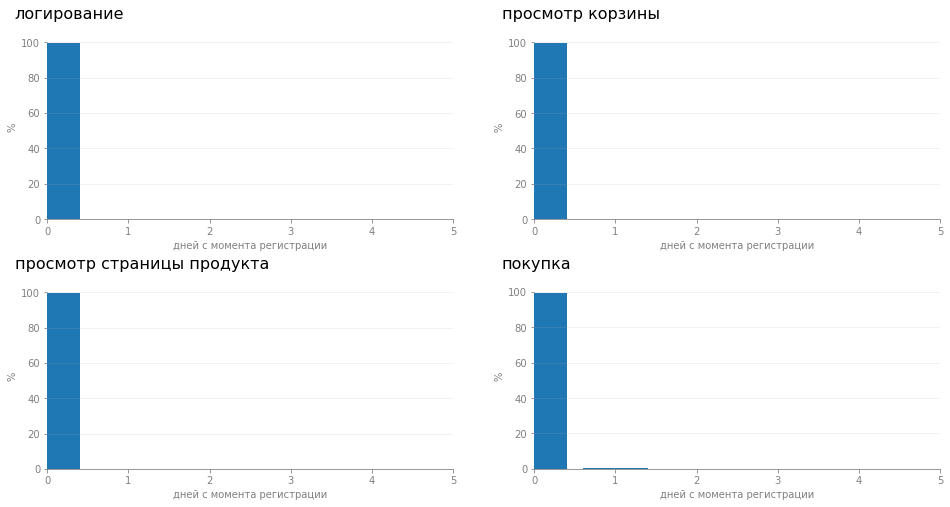

In [85]:
percent_event(events_participiant_new_user.query('group == "A"'))
print('Группа А')

Группа В


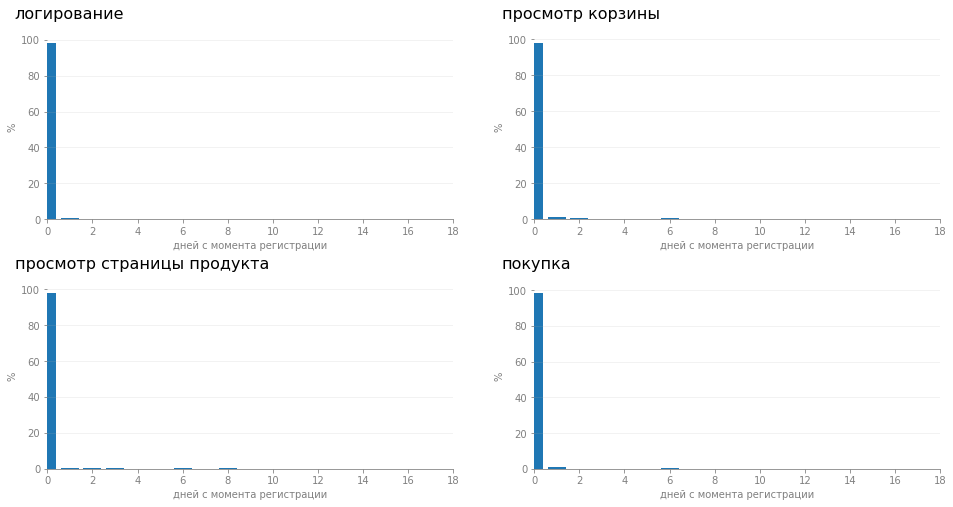

In [86]:
percent_event(events_participiant_new_user.query('group == "B"'))
print('Группа В')

__Можно отметить:__
- практически 99% пользователей совершали первое уникальное действие в день регистрации
- менее 1% пользователей в тестовой группе понадобилось больше времени для совершения первого события чем в контрольной.
- опять же возникает вопрос к метрикам теста, что именно мы хотели проверить за 14 дней!

## Как меняется конверсия в воронке в выборках на разных этапах

Всего собыитий

In [87]:
# группа А

sample_a_events['event_name'].value_counts()

login           6964
product_page    4477
purchase        2194
product_cart    2091
Name: event_name, dtype: int64

Видим, количество покупок больше чем количество просмотров карзины

In [88]:
# группа B

sample_b_events['event_name'].value_counts()

login           2004
product_page    1059
product_cart     535
purchase         525
Name: event_name, dtype: int64

___

Сколько пользователей совершали каждое из событий

In [89]:
# группа А

a_event_users = sample_a_events.groupby('event_name').agg({'user_id':'nunique'})\
    .rename(columns={'user_id':'users_a'})\
    .sort_values(by = 'users_a',ascending=False)

# добавим столбец с % от общих событий

a_event_users['%_of_events'] = a_event_users.eval('(users_a/@a_events)*100').map(lambda x: round(x, 2))
a_event_users

,users_a,%_of_events
event_name,,
login,2279,100.00
product_page,1476,64.77
purchase,734,32.21
product_cart,686,30.10


In [90]:
# индексы для правильного вывода столбцов

events_sort = pd.Series(np.arange(0, 4),
                       index=['login', 'product_page', 'product_cart', 'purchase'])

In [91]:
a_funnel = a_event_users['%_of_events']
a_funnel = a_funnel[a_funnel.index.map(events_sort)]
a_funnel

event_name
login           100.00
product_page     64.77
product_cart     30.10
purchase         32.21
Name: %_of_events, dtype: float64

In [92]:
# функция строит график воронки

def funnel(x = a_funnel.values,
          title = '\n группа А',
           color = 'grey'
          ):
    
    fig, ax = plt.subplots(figsize = (6,6))
    

    y = [4, 3, 2, 1]

    x_max = 100
    x_min = 0

    for idx, val in enumerate(x):
        left = (x_max - val)/2
        plt.barh(y[idx], x[idx], left = left, color=color, height=.9, alpha=0.8)

        plt.text(50, y[idx]-.05, x[idx], ha='center',
                 fontsize=12, color='#2A2A2A', alpha=0.8)    
    
    plt.yticks([4, 3, 2, 1], ['login', 'product_page',
                              'product_cart', 'purchase'])
    plt.xlabel('%', color='grey')
    plt.ylabel('наименование события', color='grey')
    plt.title(title, size = 16, loc='left',
                  y= 1.05, x = -0.08 )
    plt.xlim(x_min, x_max)
    
    ax.tick_params(colors='grey', labelsize = 10) # настройка значений осей
    
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('grey') #  цвет лини оси X;

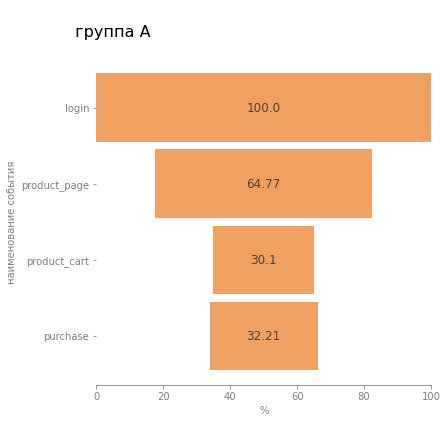

In [93]:
funnel(color = '#ed8939')

In [94]:
# группа B

b_event_users = sample_b_events.groupby('event_name').agg({'user_id':'nunique'})\
    .rename(columns={'user_id':'users_b'})\
    .sort_values(by = 'users_b',ascending=False)

# добавим столбец с % от общих событий

b_event_users['%_of_events'] = b_event_users.eval('(users_b/@b_events)*100').map(lambda x: round(x, 2))
b_event_users

,users_b,%_of_events
event_name,,
login,770,99.87
product_page,429,55.64
purchase,219,28.40
product_cart,214,27.76


In [95]:
b_funnel = b_event_users['%_of_events']
b_funnel = b_funnel[b_funnel.index.map(events_sort)]
b_funnel

event_name
login           99.87
product_page    55.64
product_cart    27.76
purchase        28.40
Name: %_of_events, dtype: float64

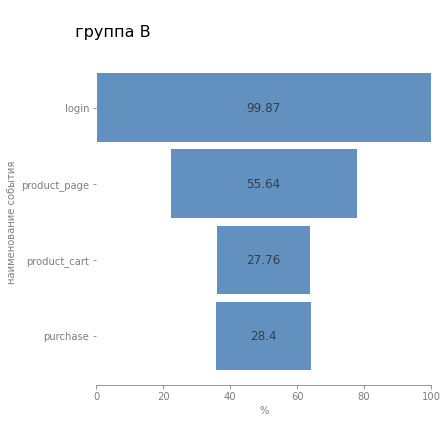

In [96]:
funnel(x = b_funnel.values,
       title='\n группа В',
    color = '#3c76af')

__Можно обратить внимание:__
- не все пользователи проходили логирование;
- покупок больше чем переходов в корзину.

In [97]:
# Посмотрим какие события совершал данный пользователь

# Сформируем список всех пользователей проходивших логирование

u_id = sample_b_events.query('event_name == "login"')['user_id'].unique()

In [98]:
# отфильтруем пользователей проходивших логирование

sample_b_events[~sample_b_events['user_id'].isin(u_id)]

,user_id,event_dt,event_name,details,first_date,max_dt_for_test
44,5FF8B6AB257B404F,2020-12-07 04:17:47,purchase,4.99,2020-12-07,2020-12-21


In [99]:
# когда пользователь был зарегистрирован

final_ab_new_users[final_ab_new_users['user_id'] == '5FF8B6AB257B404F']

,user_id,first_date,region,device
4747,5FF8B6AB257B404F,2020-12-07,EU,Android


In [100]:
# какие события совершал пользователь

final_ab_events[final_ab_events['user_id'] == '5FF8B6AB257B404F']

,user_id,event_dt,event_name,details
1411,5FF8B6AB257B404F,2020-12-07 04:17:47,purchase,4.99
53685,5FF8B6AB257B404F,2020-12-25 22:24:44,purchase,4.99
412914,5FF8B6AB257B404F,2020-12-25 22:24:44,login,NaN


__Можно обратить внимание:__
- пользователь после регистрации сразу перешел к покупке минуя все остальные этапы;
- пользователь совершил покупку сразу после логирования.

Можно предположить пользователь совершал покупку переходя по внешней ссылке.

# Особенности данных которые нужно учесть, прежде чем приступать к A/B-тестированию.

В рамках АВ-теста мы будем проверять статистическую разницу долей z-критерием. Ранее мы выяснили, что проход по всем этапам воронки не является обязательным, так что работать нужно относительно общего числа клиентов.

# Оценка результатов A/B-тестирования

## Результаты A/B-тестирования?

In [101]:
# объединим данные в выборках

ab_events = a_event_users.join(b_event_users, lsuffix='_a', rsuffix='_b')

# добавим абсолютное и относительное изменение каждой метрики 

ab_events['test_result_abs'] = ab_events['%_of_events_b'] - ab_events['%_of_events_a']
ab_events['test_result_rel'] = (((ab_events['%_of_events_b'] - ab_events['%_of_events_a'])\
    /ab_events['%_of_events_a'])*100).round(2)
ab_events

,users_a,%_of_events_a,users_b,%_of_events_b,test_result_abs,test_result_rel
event_name,,,,,,
login,2279,100.00,770,99.87,-0.13,-0.13
product_page,1476,64.77,429,55.64,-9.13,-14.10
purchase,734,32.21,219,28.40,-3.81,-11.83
product_cart,686,30.10,214,27.76,-2.34,-7.77


Можем отметить результаты в тестовой группе оказались хуже чем в контрольной.

## Проверка статистической разницы долей z-критерием

In [102]:
# Напишем функцию для расчета Z-критерия

def proportion_test(s1, s2, t1, t2, alpha=.05):
    
    # гурппа successes
    successes = np.array([s1, s2])
    
    # гурппа trials/observations
    trials = np.array([t1, t2])
    
    # пропорция 'успехов' в группе
    p1 = successes[0]/trials[0]

    p2 = successes[1]/trials[1]
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1])/ (trials[0] + trials[1])
    
    # разница пропорций в датасетах
    difference = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)
    
    #установим уровень статистической значимости:

    alpha = alpha 

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу. Различия есть.')
    
    else:
        print('Не отвергаем нулевую гипотезу, т.е. разницы нет')

Сформулируем гипотезы:

- $H_0$: статистически значимых различий в долях пользователей совершивших хотя бы один раз событие нет (группа А и группа В);
- $H_1$: различия есть;
- $\alpha$ = 0.05

Используем поправку Бонферрони на множественные сравнения.

bonferroni_alpha = $\alpha$ / 4

In [103]:
bonferroni_alpha = .05/4

for event in ab_events.index:
    # присвоим переменным значения количества пользователей совершивших 
    # хотя бы одно конкретное событие
    
    a = ab_events.loc[event]['users_a']
    b = ab_events.loc[event]['users_b']
    
    print(event)
    print('значение группы 1:', a)
    print('значение группы 2:', b)
            
    proportion_test(a, b, a_events, b_events, bonferroni_alpha)
            
    print('-'*50)

login
значение группы 1: 2279.0
значение группы 2: 770.0
p-значение:  0.08551328290029048
Не отвергаем нулевую гипотезу, т.е. разницы нет
--------------------------------------------------
product_page
значение группы 1: 1476.0
значение группы 2: 429.0
p-значение:  6.120730626113513e-06
Отвергаем нулевую гипотезу. Различия есть.
--------------------------------------------------
purchase
значение группы 1: 734.0
значение группы 2: 219.0
p-значение:  0.048942596376941205
Не отвергаем нулевую гипотезу, т.е. разницы нет
--------------------------------------------------
product_cart
значение группы 1: 686.0
значение группы 2: 214.0
p-значение:  0.21721122664962245
Не отвергаем нулевую гипотезу, т.е. разницы нет
--------------------------------------------------


Можем подтвердить статистическую значимость различий между группами клиентов совершавших событие product_page(просмотр карточек товаров)

# Общий вывод

В рамках проекта:
- оценили корректность проведения А/В теста;
- проанализировали результаты.

Тестировали: внедрение улучшенной рекомендательной системы;<br/>

Предполагаемая аудитория: 6 000 человек;<br/>

Ожидаемый эффек: увеличение метрик:
    - конверсии в просмотр карточек товаров — событие product_page;
    - просмотры корзины — product_cart;
    - покупки — purchase.
не менее, чем на 10%:

**Корректность проведения A/B теста**

*Наличие данных:*
- Группы: А (контрольная), B (новая платёжная воронка) - данные присутсвуют;
- Наличие данных за весь промежуток проведения теста: Данные присутсвуют, можем отметить сущенственное падение объема данных после 29-12-20;

*Аудитория*:
- 15% новых пользователей из региона EU - менее 15%;
- 6000 - менее 6000;
- можем отметить, далеко не все из зарегистрировавшихся пользователей прошли дальше регистрации из-за чего итоговая выборка сократилась до 3050 пользователей. 71% участников группы А и 32% участников группы В совершили какое-либо действие после регистрации. Т.к. мы тестируем рекомендательный сервис логичнее было бы отбирать пользователей после посещения главной страницы (или иной на которой начинают работать рекомендации);
- выборка изначально поделена неравномерно 57/43;
- видим различия в распределении активности(событий) пользователей. В контрольной выборке пик активности приходится на середину теста и сниженная активность в начале и в конце теста. В тестовой, пики в начале и в середине теста к концу теста спад активности. Подобное различие может говорить о поведенчиских различиях пользователей в разных группах. Что опять же говорит о неоптимальности распределения пользователей по группам.


*Время проведения теста:*
- можем отметить проведение теста в праздничные дни;
- можем отметить проведение теста в период маркетинговых активностей. <br/>
Проведение теста в данные период может привести к появлению выбросов/аномальных значений и не отражать нормальное поведение пользователей.

*Ожидаемый эффек:*
- улучшение на 10% - абсолютный или относительный прирост?
- у нас есть данные по событиям:<br/>
login -- > product_page -- > product_cart --> purchase <br/>
В такой логике клиент после логирования попадает на карточку товара;<br/>
Мы тестируем рекомендательную систему. После регистрации у нас минимум данных о пользователе, мы еще не успели собрать информацию о его поведении.<br/>
Под покупкой подразумевается переход к оформлению покупки(вводу платежных данных) или факт оплаты? Если речь идет о факте оплаты есть риск получить снижение конверсии из-за сбоя проведения оплаты;<br/>
**Можем сделать вывод**: пропущен ряд событий, рекомендательная система будет базироваться на небольшом объеме данных о пользователе;<br/>
- Обращали внимание, что пользователи после регистрации или логирования стразу переходят к покупкам минуя этап выбора товара. Еще один аргумент в пользу смены механизма отбора пользователей на ранее озвученный.

**Можем сделать вывод** о некорректности проведения теста. 

**Оценка результата**

Тестовая группа показала результат хуже контрольной.

      абсолюное / относительное значения
- login	              -0.13	   /    -0.13
- product_page		  -9.13	   /   -14.10
- product_cart	      -2.34    /   -7.77
- purchase	          -3.81	   /   -11.83

Статистическую значимость можем подтвердить только по событию product_page(просмотр карточек товаров).